In [1]:
import numpy as np
import pandas as pd
import datetime
from collections import Counter
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import re
import string
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering,
    SpectralClustering,
    AffinityPropagation,
)
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure NLTK resources are downloaded
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to C:\Users\ARYAN
[nltk_data]     PRAKASH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\ARYAN
[nltk_data]     PRAKASH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

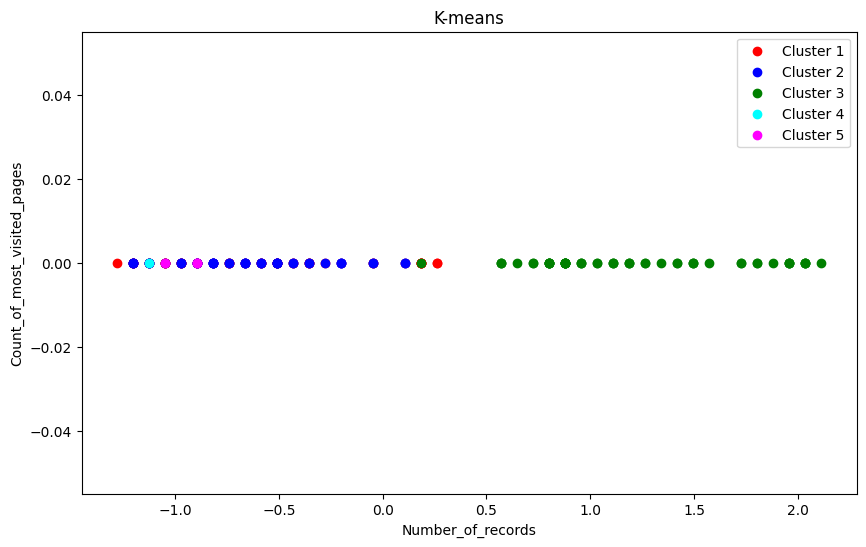

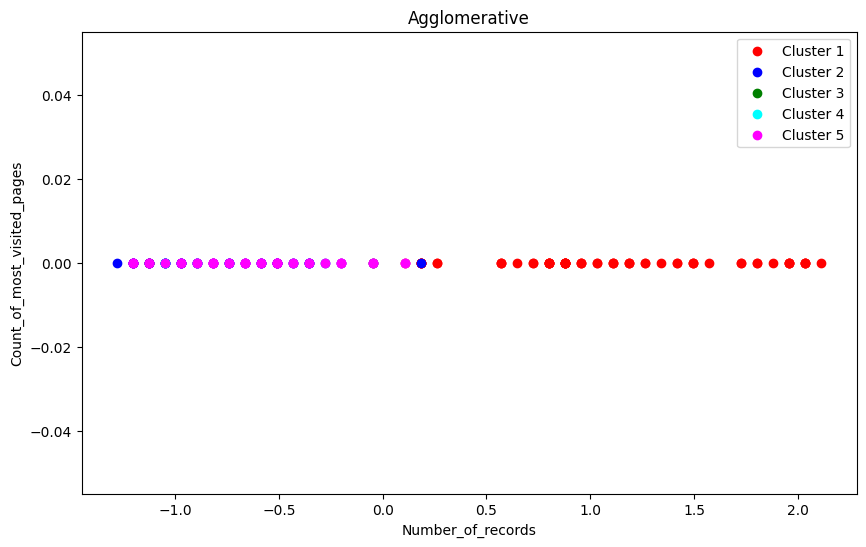

c:\Users\ARYAN PRAKASH\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


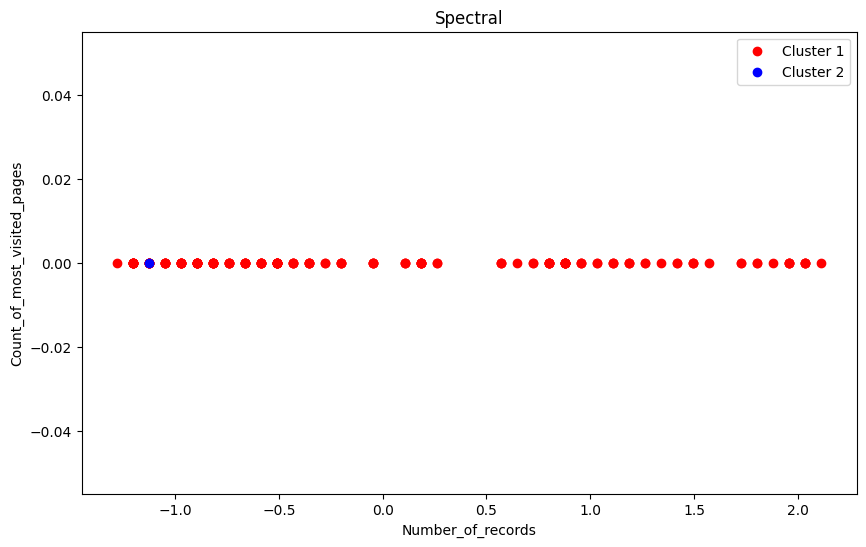

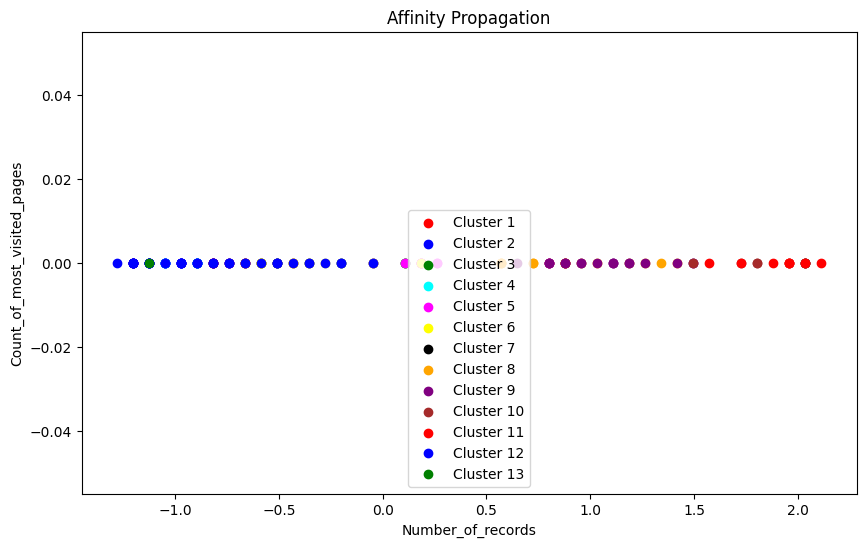

Error in main execution: could not convert string to float: '10.131.2.1 '


<Figure size 1200x800 with 0 Axes>

In [2]:
class WebLogAnalyzer:
    def __init__(self, csv_path):
        """
        Initialize analyzer with log file path
        Args:
            csv_path (str): Path to the CSV log file with columns: IP,Time,URL,Status
        """
        try:
            # Read CSV with specific column names
            self.dataset = pd.read_csv(csv_path, names=["IP", "Time", "URL", "Status"])
            self.work_dataset = None
        except Exception as e:
            print(f"Error loading CSV file: {e}")
            raise

    def preprocess_time(self, time_str):
        """
        Extract and validate time from timestamp
        Format expected: [29/Nov/2017:06:58:55
        """
        try:
            # Extract the time part from the timestamp
            time_part = time_str.split(":")[1:]
            return ":".join(time_part)
        except Exception:
            return None

    def calculate_time_difference(self, time1_str, time2_str):
        """Calculate seconds between two time strings"""
        try:
            t1 = datetime.datetime.strptime(time1_str, "%H:%M:%S")
            t2 = datetime.datetime.strptime(time2_str, "%H:%M:%S")
            return (t1 - t2).seconds
        except Exception:
            return 0

    def time_stats(self, dataframe):
        """Calculate time-based statistics"""
        try:
            time_diffs = []
            time_array = dataframe["Time"].values

            for i in range(1, len(time_array)):
                time1 = self.preprocess_time(time_array[i])
                time2 = self.preprocess_time(time_array[i - 1])

                if time1 and time2:
                    diff = self.calculate_time_difference(time1, time2)
                    time_diffs.append(diff)

            if time_diffs:
                return (
                    max(time_diffs),
                    np.mean(time_diffs),
                    sum(time_diffs),
                    np.var(time_diffs),
                )
            return 0, 0, 0, 0

        except Exception as e:
            print(f"Error in time_stats: {e}")
            return 0, 0, 0, 0

    def clean_url_text(self, text):
        """Clean and normalize URL text"""
        text = str(text).lower()
        text = re.sub(r"\d+", "", text)
        text = text.translate(str.maketrans("", "", string.punctuation))
        return text.strip()

    def bigram_stats(self, dataframe):
        """Calculate n-gram statistics from URLs"""
        try:
            url_array = dataframe["URL"].values
            full_string = " ".join(str(url) for url in url_array)
            full_string = self.clean_url_text(full_string)

            stop_words = {"get", "post", "httpget", "httppost"}
            tokens = [
                word for word in word_tokenize(full_string) if word not in stop_words
            ]

            if not tokens:
                return 0, 0, 0, 0

            return (
                Counter(tokens).most_common(1)[0][1] if tokens else 0,
                (
                    Counter(list(ngrams(tokens, 2))).most_common(1)[0][1]
                    if len(tokens) > 1
                    else 0
                ),
                (
                    Counter(list(ngrams(tokens, 3))).most_common(1)[0][1]
                    if len(tokens) > 2
                    else 0
                ),
                (
                    Counter(list(ngrams(tokens, 6))).most_common(1)[0][1]
                    if len(tokens) > 5
                    else 0
                ),
            )

        except Exception as e:
            print(f"Error in bigram_stats: {e}")
            return 0, 0, 0, 0

    def process_chunk(self, chunk_df):
        """Process a single chunk of log data"""
        try:
            max_time_diff, mean_time_diff, sum_time_diff, variance_time_diff = (
                self.time_stats(chunk_df)
            )
            count_visited, bigrams, trigrams, ngrams = self.bigram_stats(chunk_df)

            most_common_ip = (
                chunk_df["IP"].mode().iloc[0] if not chunk_df.empty else "0.0.0.0"
            )
            most_common_status = (
                chunk_df["Status"].mode().iloc[0] if not chunk_df.empty else 0
            )

            return [
                most_common_ip,
                mean_time_diff,
                variance_time_diff,
                sum_time_diff,
                max_time_diff,
                bigrams,
                trigrams,
                ngrams,
                count_visited,
                most_common_status,
                len(chunk_df),
            ]

        except Exception as e:
            print(f"Error in process_chunk: {e}")
            return None

    def process_daily_logs(self):
        """Process logs grouped by time periods"""
        try:
            data_rows = []
            chunk_size = 100  # Process in chunks of 100 records

            # Process logs in chunks
            for i in range(0, len(self.dataset), chunk_size):
                chunk_df = self.dataset.iloc[i : i + chunk_size]
                stats = self.process_chunk(chunk_df)
                if stats:
                    data_rows.append(stats)

            # Create work dataset
            self.work_dataset = pd.DataFrame(
                data_rows,
                columns=[
                    "IP_Address",
                    "Time_Difference_Mean",
                    "Time_Difference_Variance",
                    "Time_Difference_Sum",
                    "Time_Difference_Maximum",
                    "Character-bigrams",
                    "Character-trigrams",
                    "Character-ngrams",
                    "Count_of_most_visited_page",
                    "Status",
                    "Number_of_records",
                ],
            )

        except Exception as e:
            print(f"Error in process_daily_logs: {e}")

    def prepare_for_clustering(self):
        """Prepare data for clustering analysis"""
        try:
            # Convert IPs to numerical values
            self.work_dataset["IP_rep"] = self.work_dataset["IP_Address"].apply(
                lambda x: int("".join([f"{int(octet):03d}" for octet in x.split(".")]))
            )

            # Standardize features
            X = self.work_dataset.drop("IP_Address", axis=1).values
            scaler = StandardScaler()
            return scaler.fit_transform(X)

        except Exception as e:
            print(f"Error in prepare_for_clustering: {e}")
            return None

    def perform_clustering(self, X, n_clusters=5):
        """Perform multiple clustering algorithms"""
        if X is None:
            print("No data available for clustering")
            return

        clustering_algorithms = {
            "K-means": KMeans(n_clusters=n_clusters, random_state=0),
            "Agglomerative": AgglomerativeClustering(n_clusters=n_clusters),
            "Spectral": SpectralClustering(n_clusters=n_clusters, random_state=0),
            "Affinity Propagation": AffinityPropagation(damping=0.5, max_iter=250),
        }

        for name, algorithm in clustering_algorithms.items():
            try:
                labels = algorithm.fit_predict(X)
                self.plot_clusters(X, labels, name)
            except Exception as e:
                print(f"Error in {name} clustering: {e}")

    def plot_clusters(self, X, labels, title):
        """Plot clustering results"""
        plt.figure(figsize=(10, 6))
        colors = [
            "red",
            "blue",
            "green",
            "cyan",
            "magenta",
            "yellow",
            "black",
            "orange",
            "purple",
            "brown",
        ]

        unique_labels = set(labels)
        for i, label in enumerate(unique_labels):
            mask = labels == label
            plt.scatter(
                X[mask, 4],
                X[mask, 3],
                c=colors[i % len(colors)],
                label=f"Cluster {label+1}",
            )

        plt.title(title)
        plt.xlabel("Number_of_records")
        plt.ylabel("Count_of_most_visited_pages")
        plt.legend()
        plt.show()

    def plot_correlation_heatmap(self):
        """Plot correlation heatmap of features"""
        if self.work_dataset is not None:
            plt.figure(figsize=(12, 8))
            sns.heatmap(
                self.work_dataset.corr(), annot=True, cmap="coolwarm", square=True
            )
            plt.title("Feature Correlation Heatmap")
            plt.show()


def main():
    try:
        # Initialize analyzer
        analyzer = WebLogAnalyzer("weblog.csv")

        # Process logs
        analyzer.process_daily_logs()

        # Prepare and perform clustering
        X = analyzer.prepare_for_clustering()
        analyzer.perform_clustering(X)

        # Plot correlation heatmap
        analyzer.plot_correlation_heatmap()

    except Exception as e:
        print(f"Error in main execution: {e}")


if __name__ == "__main__":
    main()